# Modello U-net doppia
In questo notebook è riportato un modello costituito da due U-net in parallelo concatenate alla fine.

La prima è costituita da 3 blocchi per l'encoder e 3 blocchi per il decoder. Ogni blocco ha stack = 2 ed è costituito dalla sequenza di layers: Convoluzione-1, Convoluzione-2 Batch Normalization e Attivazione. Infine un ultimo blocco viene richiamato nel bottleneck. In più è stato aggiunto il regularizer l2.

La seconda U-net invece sempre da 3 blocchi per l'encoding e 3 per il decoding + 1 blocco nel bottleneck con kernel maggiore rispetto alla prima U-net e con solo una convoluzione anzichè due.

Come loss function è stata implementata una weighted_sparse_categorical_crossentropy che tenga conto dei pesi calcolati per le classi (tiene conto dello sbilanciamento)

Questo è un esempio di rete con due U-net ma sono stati fatti diversi tentativi modificando: il numero di blocchi in sequenza, i kernel, i filtri, lo stack, loss function. In ogni caso la performance è rimasta inferiore rispetto a quella raggiunta poi nel best model con una U-net singola.


**Connect Colab to Google Drive**

In [1]:
from google.colab import drive
drive.mount("/gdrive")

%cd /gdrive/My Drive/U-net

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/U-net


**Import Libraries**

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [3]:
seed = 42

**Load the Data**

In [4]:
data = np.load("mars_for_students_processed.npz")

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [5]:
from matplotlib.colors import ListedColormap

class_colors = {
    0: "black",     # Background
    1: "brown",     # Soil
    2: "gray",      # Bedrock
    3: "yellow",    # Sand
    4: "darkgreen"  # Big Rock
}
cmap = ListedColormap([class_colors[key] for key in sorted(class_colors.keys())])

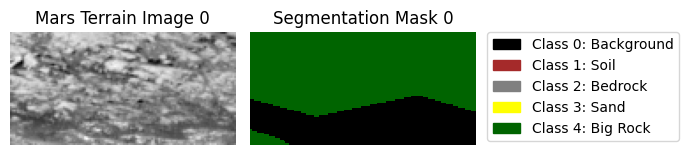

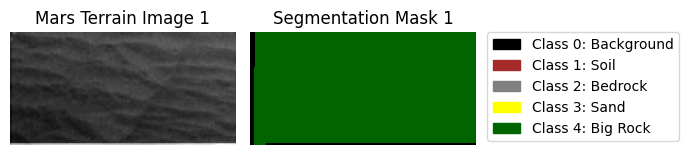

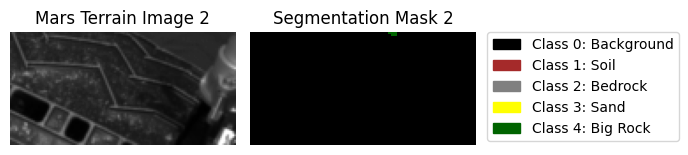

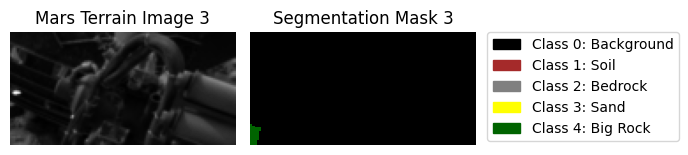

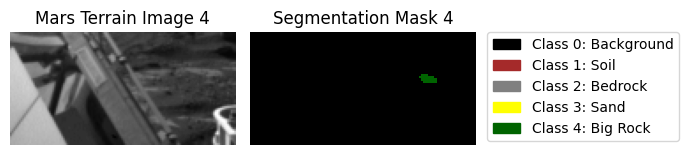

In [6]:
# Legend
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=class_colors[i], label=f"Class {i}: {label}")
                  for i, label in enumerate(["Background", "Soil", "Bedrock", "Sand", "Big Rock"])]

def display_images_with_masks(X_train, y_train, start, end):
    for i in range(start, end):
        image = X_train[i]
        mask = y_train[i]

        # Plot di immagini e maschere
        plt.figure(figsize=(7, 5))

        # immagini
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Mars Terrain Image {i}")
        plt.axis("off")

        # maschere
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap=cmap, interpolation="none")
        plt.title(f"Segmentation Mask {i}")
        plt.axis("off")

        # legenda
        plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.show()

display_images_with_masks(X_train, y_train, start=0, end=5)

## Creazione del dataset

**Parametri**

In [7]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
PATIENCE = 30
EPOCHS = 1000
SPLITS_SIZE = 300

**Funzione di augmentation**

In [8]:
@tf.function
def random_zoom(image, label, zoom_range=(0.7, 1.3), seed=None):

    # If no seed is provided, generate one using TensorFlow
    if seed is None:
        seed = tf.random.uniform([], 0, 1000000, dtype=tf.int32)

    # Generate a random zoom factor
    zoom_factor = tf.random.uniform([], zoom_range[0], zoom_range[1], seed=seed)

    # Resize the image and label by the zoom factor
    image = tf.image.resize(image, [tf.cast(tf.shape(image)[0] * zoom_factor, tf.int32),
                                    tf.cast(tf.shape(image)[1] * zoom_factor, tf.int32)])
    label = tf.image.resize(label, [tf.cast(tf.shape(label)[0] * zoom_factor, tf.int32),
                                    tf.cast(tf.shape(label)[1] * zoom_factor, tf.int32)])

    # Center-crop the image and label back to their original shape
    image = tf.image.resize_with_crop_or_pad(image, target_height=tf.shape(image)[0], target_width=tf.shape(image)[1])
    label = tf.image.resize_with_crop_or_pad(label, target_height=tf.shape(label)[0], target_width=tf.shape(label)[1])

    return image, label

**Costruttori dataset**

In [9]:
# COSTRUTTORE TRAINING SET
def make_dataset(X_in, y_in, batch_size, shuffle=True, augment=False, seed=None):

    dataset = tf.data.Dataset.from_tensor_slices((X_in, y_in))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    dataset = dataset.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_zoom(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.batch(batch_size, drop_remainder=False)

    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [10]:
# COSTRUTTORE TEST SET

def make_test_dataset(X_test, batch_size, shuffle=False, seed=None):

    dataset = tf.data.Dataset.from_tensor_slices(X_test)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    dataset = dataset.map(
        lambda x: tf.cast(x, tf.float32) / 255.0,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size, drop_remainder=False)

    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

**Split train-validation**

In [11]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [12]:
from sklearn.model_selection import train_test_split

train_img, val_img, train_lbl, val_lbl = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

print(f"Train images shape: {train_img.shape}")
print(f"Train labels shape: {train_lbl.shape}")
print(f"Validation images shape: {val_img.shape}")
print(f"Validation labels shape: {val_lbl.shape}")

Train images shape: (2004, 64, 128, 1)
Train labels shape: (2004, 64, 128)
Validation images shape: (501, 64, 128, 1)
Validation labels shape: (501, 64, 128)


**Creazione dei set**

In [13]:
# distribuzione delle classi

def calculate_class_weights(masks, num_classes):
  # Conta i pixel per ogni classe
  total_pixels = np.prod(masks.shape)
  class_counts = np.array([np.sum(masks == c) for c in range(num_classes)])

  class_counts = np.maximum(class_counts, 1)

  # Calcola i pesi
  class_weights = total_pixels / (num_classes * class_counts)

  return class_weights

In [14]:
# calcolo i pesi
weights = calculate_class_weights(train_lbl, num_classes=5)
# Vettore dei pesi per le classi
weights = tf.convert_to_tensor(weights, dtype=tf.float32)
print("Pesi delle classi:", weights)

Pesi delle classi: tf.Tensor([  0.8249854    0.5935028    0.83660996   1.1096944  153.93846   ], shape=(5,), dtype=float32)


In [15]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_dataset = make_test_dataset(
    X_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128)
Labels dtype: <dtype: 'int32'>


**LOSS FUNCTION weighted_sparse_categorical_crossentropy**

In [16]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Funzione di perdita con pesi
def weighted_sparse_categorical_crossentropy(y_true, y_pred):
    # Pesi
    class_weights = tf.gather(weights, tf.cast(y_true, tf.int32))
    # Calcola la Sparse Categorical Crossentropy
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    loss = scce(y_true, y_pred)
    # Applica i pesi alla loss (moltiplica la loss per i pesi per le classi corrispondenti)
    weighted_loss = class_weights * loss
    # Ritorna la media della loss pesata
    return tf.reduce_mean(weighted_loss)

## Definizione del modello double U-net

**Blocco U-net 1**

In [17]:
from tensorflow.keras.regularizers import l2

def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):

    x = input_tensor

    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_regularizer = l2(0.01), name=name + 'conv' + str(i+1))(x)
        x = tfkl.Conv2D(filters, kernel_size=1, padding='same', kernel_regularizer = l2(0.01), name=name + 'conv1' + str(i+1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    return x

**Blocco U-net 2**

In [18]:
from tensorflow.keras.regularizers import l2

def unet_block_p(input_tensor, filters, kernel_size=7, activation='relu', stack=2, name=''):

    x = input_tensor

    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_regularizer = l2(0.01), name=name + 'conv_p' + str(i+1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    return x

**Modello**

In [19]:
def get_unet_model(input_shape=input_shape, num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

# UNET 1

    # Downsampling
    down_block_1 = unet_block(input_layer, 16, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 32, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 64, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 128, name='bottleneck')

    # Upsampling

    u2 = tfkl.UpSampling2D()(bottleneck)
    u2 = tfkl.Concatenate()([u2, down_block_3])
    u2 = unet_block(u2, 64, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2])
    u3 = unet_block(u3, 32, name='up_block3_')

    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1])
    u4 = unet_block(u4, 16, name='up_block4_')

# UNET 2

    # Downsampling
    down_block_1_p = unet_block_p(input_layer, 16, name='down_block1_p')
    d1_p = tfkl.MaxPooling2D()(down_block_1_p)

    down_block_2_p = unet_block_p(d1_p, 32, name='down_block2_p')
    d2_p = tfkl.MaxPooling2D()(down_block_2_p)

    down_block_3_p = unet_block_p(d2_p, 64, name='down_block3_p')
    d3_p = tfkl.MaxPooling2D()(down_block_3_p)

    # Bottleneck
    bottleneck_p = unet_block_p(d3_p, 128, name='bottleneck_p')

    # Upsampling
    u2_p = tfkl.UpSampling2D()(bottleneck_p)
    u2_p = tfkl.Concatenate()([u2_p, down_block_3_p])
    u2_p = unet_block_p(u2_p, 64, name='up_block2_p')

    u3_p = tfkl.UpSampling2D()(u2_p)
    u3_p = tfkl.Concatenate()([u3_p, down_block_2_p])
    u3_p = unet_block_p(u3_p, 32, name='up_block3_p')

    u4_p = tfkl.UpSampling2D()(u3_p)
    u4_p = tfkl.Concatenate()([u4_p, down_block_1_p])
    u4_p = unet_block_p(u4_p, 16, name='up_block4_p')

    # Output Layer
    output = tfkl.Concatenate()([u4, u4_p]) ### concatenazione delle 2
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(output)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [20]:
model = get_unet_model()

# Summary
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 16)  │          160 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv11     │ (None, 64, 128, 16)  │          272 │ down_block1_conv1[… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 16)  │           64 │ down_block1_conv11… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 16)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 16)  │        2,320 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv12     │ (None, 64, 128, 16)  │          272 │ down_block1_conv2[… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 16)  │           64 │ down_block1_conv12… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 16)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 16)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 32)   │        4,640 │ max_pooling2d[0][0] │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv11     │ (None, 32, 64, 32)   │        1,056 │ down_block2_conv1[… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 32)   │          128 │ down_block2_conv11… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 3,196,037 (12.19 MB)

 Trainable params: 3,193,221 (12.18 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [21]:
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False, name='mean_iou')

model.compile(optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
              loss=SparseCategoricalCrossentropy,
              metrics=["accuracy", mean_iou])

**Callbacks**

In [22]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',
    mode = 'max',
    factor=0.1,
    patience=10,
    min_delta=1e-5
)

In [23]:
def apply_colormap(label, colormap=None):

    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = cmap

    # Normalize the label to fit colormap's range [0, 1]
    normalized_label = label.astype(np.float32) / (np.max(label) if np.max(label) > 0 else 1)

    # Apply the colormap as a function
    colored = colormap(normalized_label)

    return colored

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5, num_classes=5):

        super().__init__()
        self.images = images
        self.labels = labels
        self.frequency = frequency
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Use a random index from the provided images
            idx = np.random.randint(0, len(self.images))
            image = self.images[idx]
            label = self.labels[idx]

            # Expand image dims to simulate batch for model prediction
            image_batch = tf.expand_dims(image, 0)

            # Predict the segmentation mask
            pred = self.model.predict(image_batch, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()[0]  # Convert to NumPy

            # Visualization
            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image.squeeze(), cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, cmap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred, cmap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

viz_callback = VizCallback(val_img, val_lbl, frequency=5, num_classes=5)

In [24]:
for train_img, train_lbl in train_dataset.take(1):
    print("Forma immagine:", train_img.shape)
    print("Forma maschera:", train_lbl.shape)

Forma immagine: (64, 64, 128, 1)
Forma maschera: (64, 64, 128)


Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3421 - loss: 18.0257 - mean_iou: 0.1433   

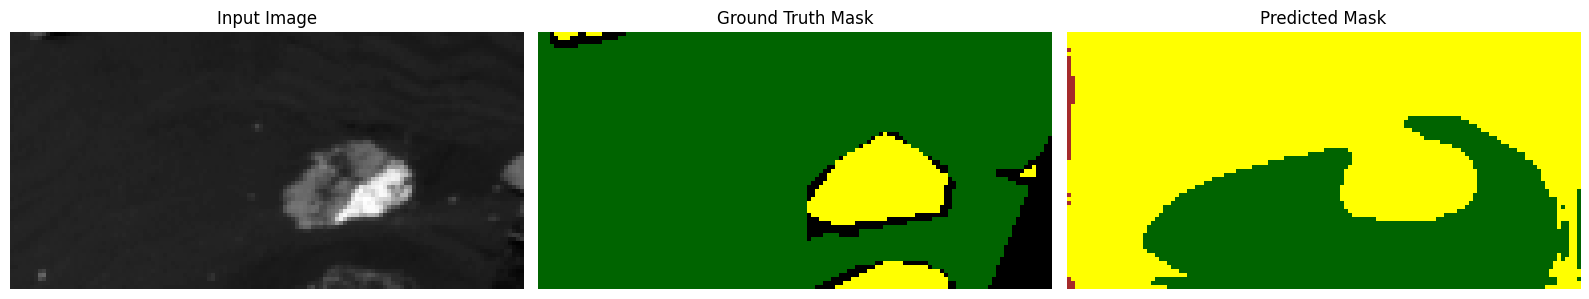

32/32 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.3448 - loss: 17.9248 - mean_iou: 0.1451 - val_accuracy: 0.2116 - val_loss: 9.7315 - val_mean_iou: 0.0824 - learning_rate: 0.0010
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.5572 - loss: 8.2716 - mean_iou: 0.2914 - val_accuracy: 0.3473 - val_loss: 6.4879 - val_mean_iou: 0.1151 - learning_rate: 0.0010
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.5875 - loss: 5.4704 - mean_iou: 0.3145 - val_accuracy: 0.3474 - val_loss: 4.9987 - val_mean_iou: 0.1152 - learning_rate: 0.0010
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - accuracy: 0.5883 - loss: 4.1439 - mean_iou: 0.3232 - val_accuracy: 0.3478 - val_loss: 3.9314 - val_mean_iou: 0.0925 - learning_rate: 0.0010
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.6206 - loss: 3.2601 - mean_iou: 0.3506 - val_accuracy: 0.3473 - val_loss: 3.3891 - val_mean_iou: 0.1151 - learning_rate: 0.0010
Epoch 6/1000
32/32 ━━━━━━━━━━

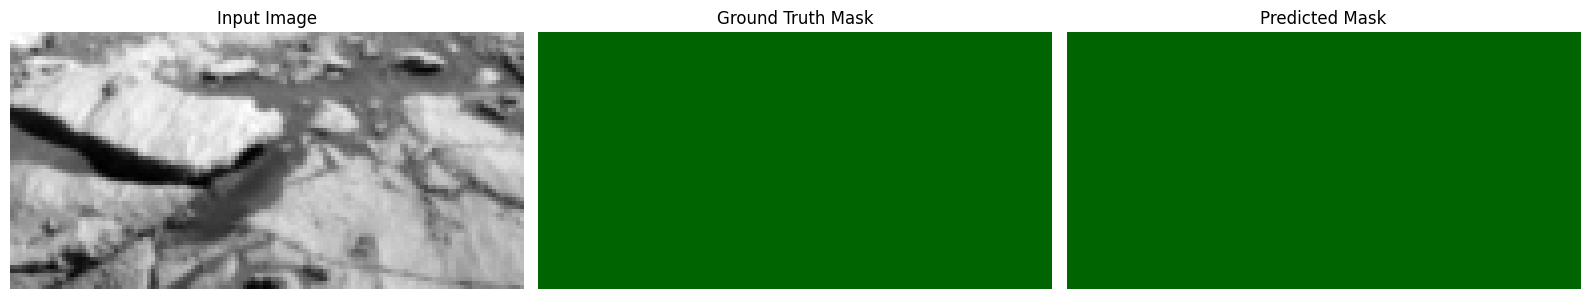

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.6487 - loss: 2.6631 - mean_iou: 0.3637 - val_accuracy: 0.3481 - val_loss: 2.9673 - val_mean_iou: 0.0920 - learning_rate: 0.0010
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.6463 - loss: 2.3798 - mean_iou: 0.3690 - val_accuracy: 0.3490 - val_loss: 2.6800 - val_mean_iou: 0.0920 - learning_rate: 0.0010
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - accuracy: 0.6517 - loss: 2.0885 - mean_iou: 0.3720 - val_accuracy: 0.3688 - val_loss: 2.4034 - val_mean_iou: 0.0919 - learning_rate: 0.0010
Epoch 9/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.6633 - loss: 1.8568 - mean_iou: 0.3852 - val_accuracy: 0.3477 - val_loss: 2.3730 - val_mean_iou: 0.0921 - learning_rate: 0.0010
Epoch 10/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 0.6755 - loss: 1.7028 - mean_iou: 0.4012 - val_accuracy: 0.3363 - val_loss: 2.1373 - val_mean_iou: 0.0692 - learning_rate: 0.0010
Epoch 11/1000
32/32 ━━━━━━━

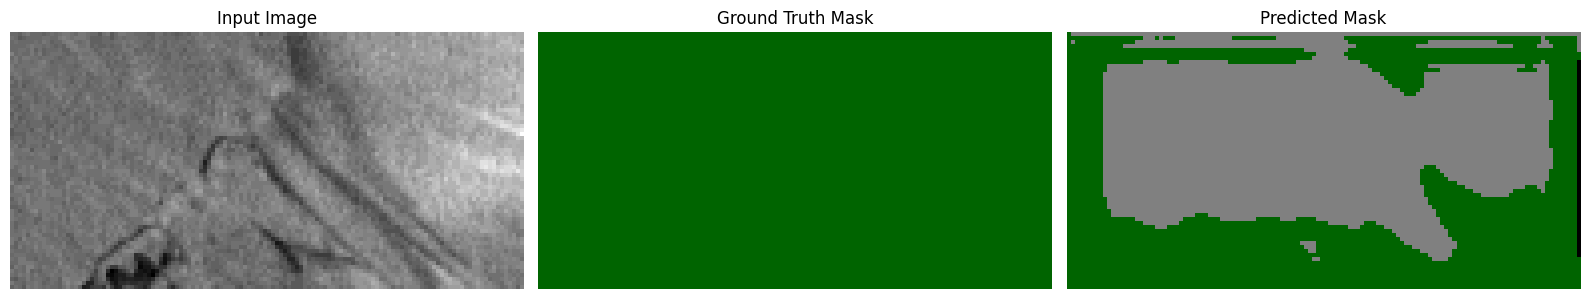

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - accuracy: 0.6649 - loss: 1.6529 - mean_iou: 0.3774 - val_accuracy: 0.3509 - val_loss: 2.1024 - val_mean_iou: 0.0920 - learning_rate: 0.0010
Epoch 12/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.6686 - loss: 1.5903 - mean_iou: 0.3893 - val_accuracy: 0.2086 - val_loss: 2.3722 - val_mean_iou: 0.0524 - learning_rate: 0.0010
Epoch 13/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - accuracy: 0.6895 - loss: 1.5279 - mean_iou: 0.4091 - val_accuracy: 0.3222 - val_loss: 2.0262 - val_mean_iou: 0.1042 - learning_rate: 0.0010
Epoch 14/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.6909 - loss: 1.4559 - mean_iou: 0.4086 - val_accuracy: 0.3859 - val_loss: 1.9868 - val_mean_iou: 0.1178 - learning_rate: 1.0000e-04
Epoch 15/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.7133 - loss: 1.3653 - mean_iou: 0.4349 - val_accuracy: 0.4284 - val_loss: 1.9156 - val_mean_iou: 0.1537 - learning_rate: 1.0000e-04
Epoch 16/1000
32

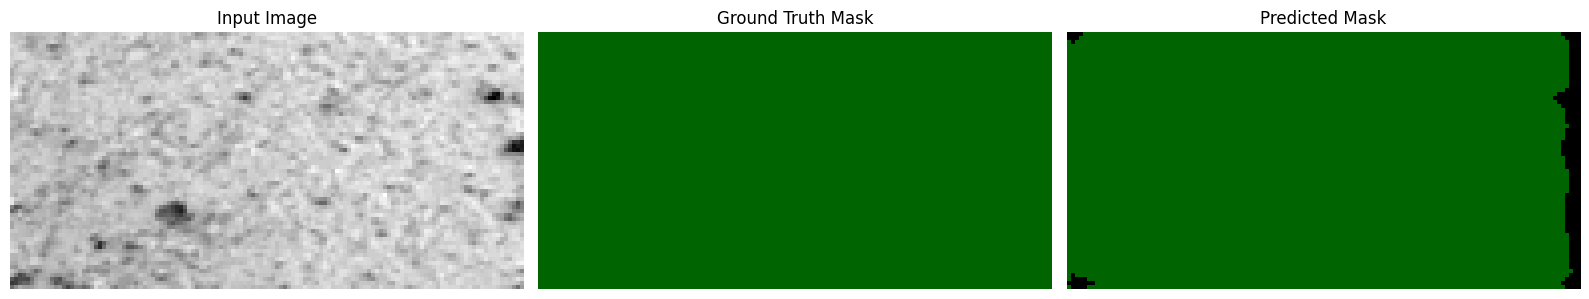

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 376ms/step - accuracy: 0.7201 - loss: 1.3205 - mean_iou: 0.4372 - val_accuracy: 0.4391 - val_loss: 1.8941 - val_mean_iou: 0.1631 - learning_rate: 1.0000e-04
Epoch 17/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.7257 - loss: 1.2824 - mean_iou: 0.4405 - val_accuracy: 0.4558 - val_loss: 1.8719 - val_mean_iou: 0.1754 - learning_rate: 1.0000e-04
Epoch 18/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.7316 - loss: 1.2578 - mean_iou: 0.4459 - val_accuracy: 0.4651 - val_loss: 1.8416 - val_mean_iou: 0.1892 - learning_rate: 1.0000e-04
Epoch 19/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - accuracy: 0.7312 - loss: 1.2441 - mean_iou: 0.4447 - val_accuracy: 0.4997 - val_loss: 1.8038 - val_mean_iou: 0.2005 - learning_rate: 1.0000e-04
Epoch 20/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.7315 - loss: 1.2440 - mean_iou: 0.4414 - val_accuracy: 0.4870 - val_loss: 1.7744 - val_mean_iou: 0.2092 - learning_rate: 1.0000e-04
Epoc

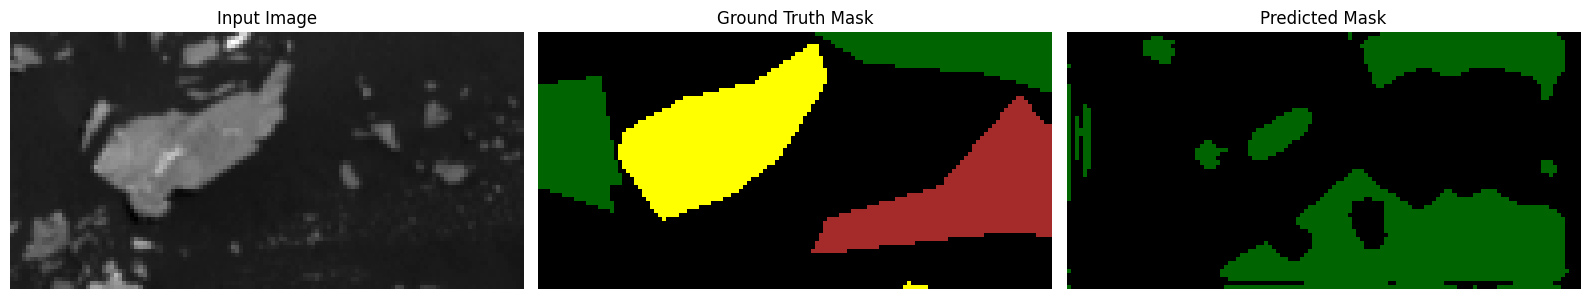

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - accuracy: 0.7396 - loss: 1.2140 - mean_iou: 0.4557 - val_accuracy: 0.5523 - val_loss: 1.6823 - val_mean_iou: 0.2503 - learning_rate: 1.0000e-04
Epoch 22/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 345ms/step - accuracy: 0.7382 - loss: 1.1927 - mean_iou: 0.4566 - val_accuracy: 0.4494 - val_loss: 1.7307 - val_mean_iou: 0.1760 - learning_rate: 1.0000e-04
Epoch 23/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.7426 - loss: 1.1764 - mean_iou: 0.4535 - val_accuracy: 0.5509 - val_loss: 1.6658 - val_mean_iou: 0.2522 - learning_rate: 1.0000e-04
Epoch 24/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.7376 - loss: 1.1838 - mean_iou: 0.4494 - val_accuracy: 0.5293 - val_loss: 1.6640 - val_mean_iou: 0.2441 - learning_rate: 1.0000e-04
Epoch 25/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.7418 - loss: 1.1694 - mean_iou: 0.4513 - val_accuracy: 0.5556 - val_loss: 1.5957 - val_mean_iou: 0.2647 - learning_rate: 1.0000e-04
Epoc

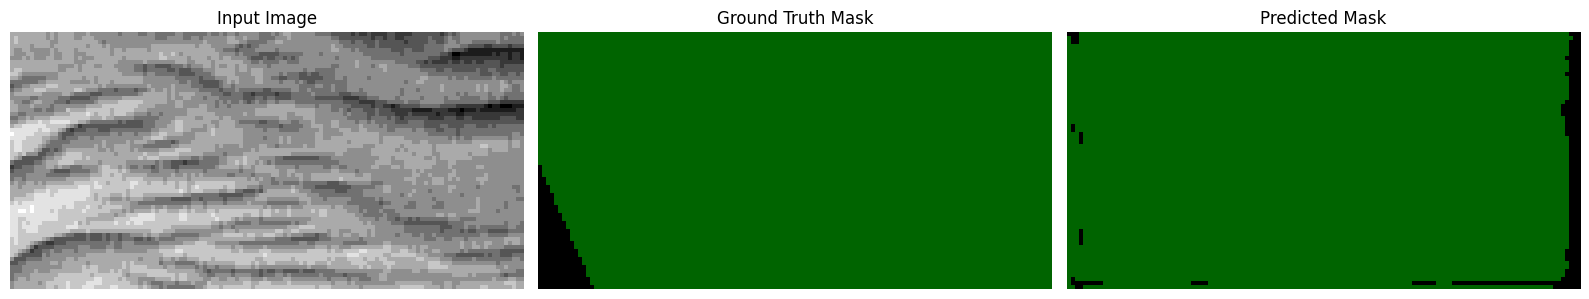

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.7502 - loss: 1.1497 - mean_iou: 0.4614 - val_accuracy: 0.6142 - val_loss: 1.5476 - val_mean_iou: 0.3439 - learning_rate: 1.0000e-04
Epoch 27/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.7482 - loss: 1.1490 - mean_iou: 0.4635 - val_accuracy: 0.6308 - val_loss: 1.4938 - val_mean_iou: 0.3526 - learning_rate: 1.0000e-04
Epoch 28/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.7505 - loss: 1.1311 - mean_iou: 0.4632 - val_accuracy: 0.6160 - val_loss: 1.4830 - val_mean_iou: 0.3308 - learning_rate: 1.0000e-04
Epoch 29/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.7557 - loss: 1.1179 - mean_iou: 0.4641 - val_accuracy: 0.6287 - val_loss: 1.4802 - val_mean_iou: 0.3530 - learning_rate: 1.0000e-04
Epoch 30/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.7501 - loss: 1.1273 - mean_iou: 0.4598 - val_accuracy: 0.6714 - val_loss: 1.3795 - val_mean_iou: 0.3825 - learning_rate: 1.0000e-04
Epoc

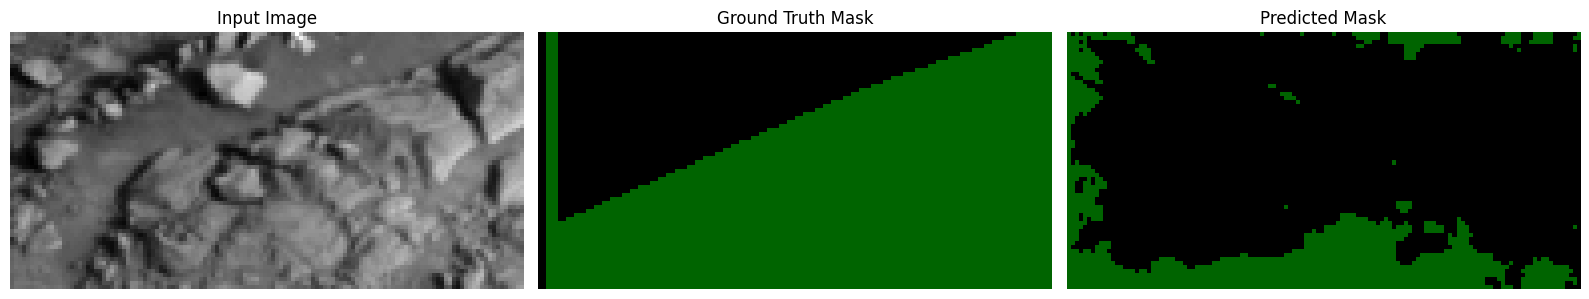

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 376ms/step - accuracy: 0.7483 - loss: 1.1277 - mean_iou: 0.4584 - val_accuracy: 0.6773 - val_loss: 1.3959 - val_mean_iou: 0.3929 - learning_rate: 1.0000e-04
Epoch 32/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7606 - loss: 1.0913 - mean_iou: 0.4673 - val_accuracy: 0.6360 - val_loss: 1.3930 - val_mean_iou: 0.3648 - learning_rate: 1.0000e-04
Epoch 33/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.7593 - loss: 1.0936 - mean_iou: 0.4656 - val_accuracy: 0.6732 - val_loss: 1.3665 - val_mean_iou: 0.3787 - learning_rate: 1.0000e-04
Epoch 34/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.7615 - loss: 1.0881 - mean_iou: 0.4719 - val_accuracy: 0.6774 - val_loss: 1.3799 - val_mean_iou: 0.3873 - learning_rate: 1.0000e-04
Epoch 35/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 366ms/step - accuracy: 0.7619 - loss: 1.0750 - mean_iou: 0.4734 - val_accuracy: 0.6511 - val_loss: 1.3965 - val_mean_iou: 0.3515 - learning_rate: 1.0000e-04
Epoc

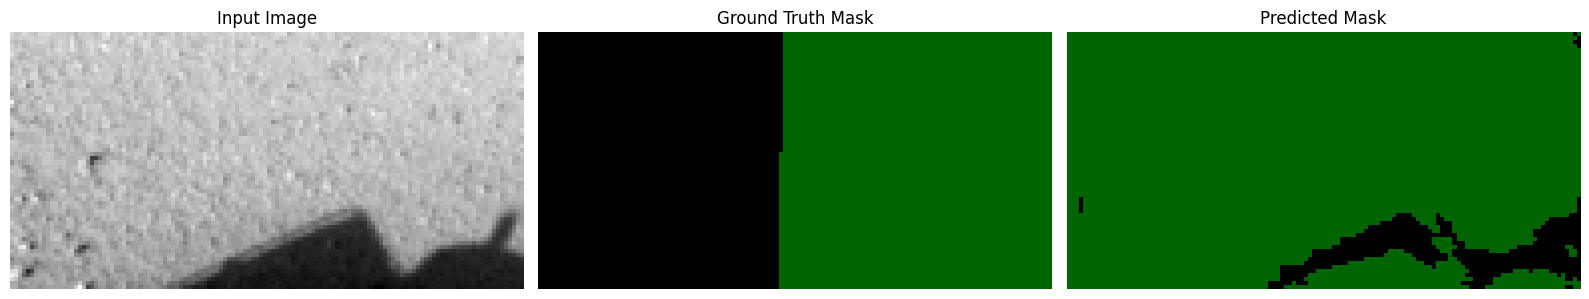

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.7624 - loss: 1.0662 - mean_iou: 0.4696 - val_accuracy: 0.6664 - val_loss: 1.3469 - val_mean_iou: 0.3654 - learning_rate: 1.0000e-04
Epoch 37/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.7624 - loss: 1.0649 - mean_iou: 0.4742 - val_accuracy: 0.6795 - val_loss: 1.3360 - val_mean_iou: 0.3583 - learning_rate: 1.0000e-04
Epoch 38/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.7649 - loss: 1.0582 - mean_iou: 0.4714 - val_accuracy: 0.6731 - val_loss: 1.3002 - val_mean_iou: 0.3715 - learning_rate: 1.0000e-04
Epoch 39/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.7700 - loss: 1.0458 - mean_iou: 0.4767 - val_accuracy: 0.6970 - val_loss: 1.2666 - val_mean_iou: 0.3873 - learning_rate: 1.0000e-04
Epoch 40/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.7624 - loss: 1.0647 - mean_iou: 0.4678 - val_accuracy: 0.6199 - val_loss: 1.3610 - val_mean_iou: 0.2865 - learning_rate: 1.0000e-04
Epoc

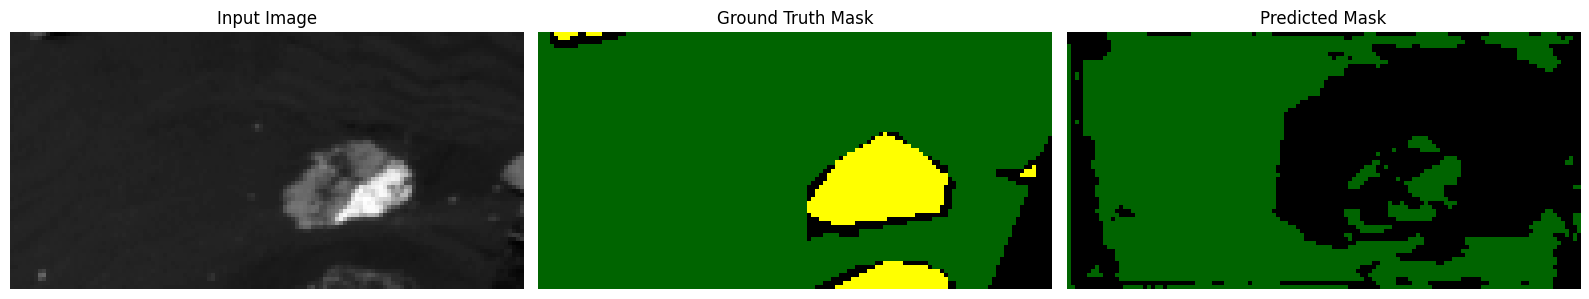

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.7718 - loss: 1.0356 - mean_iou: 0.4788 - val_accuracy: 0.6790 - val_loss: 1.2520 - val_mean_iou: 0.3754 - learning_rate: 1.0000e-04
Epoch 42/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.7792 - loss: 1.0197 - mean_iou: 0.4859 - val_accuracy: 0.7419 - val_loss: 1.1719 - val_mean_iou: 0.4370 - learning_rate: 1.0000e-05
Epoch 43/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.7910 - loss: 0.9849 - mean_iou: 0.5021 - val_accuracy: 0.7327 - val_loss: 1.1720 - val_mean_iou: 0.4163 - learning_rate: 1.0000e-05
Epoch 44/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.7943 - loss: 0.9801 - mean_iou: 0.5006 - val_accuracy: 0.7278 - val_loss: 1.1693 - val_mean_iou: 0.4061 - learning_rate: 1.0000e-05
Epoch 45/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.7950 - loss: 0.9675 - mean_iou: 0.5034 - val_accuracy: 0.7543 - val_loss: 1.1148 - val_mean_iou: 0.4436 - learning_rate: 1.0000e-05
Epoc

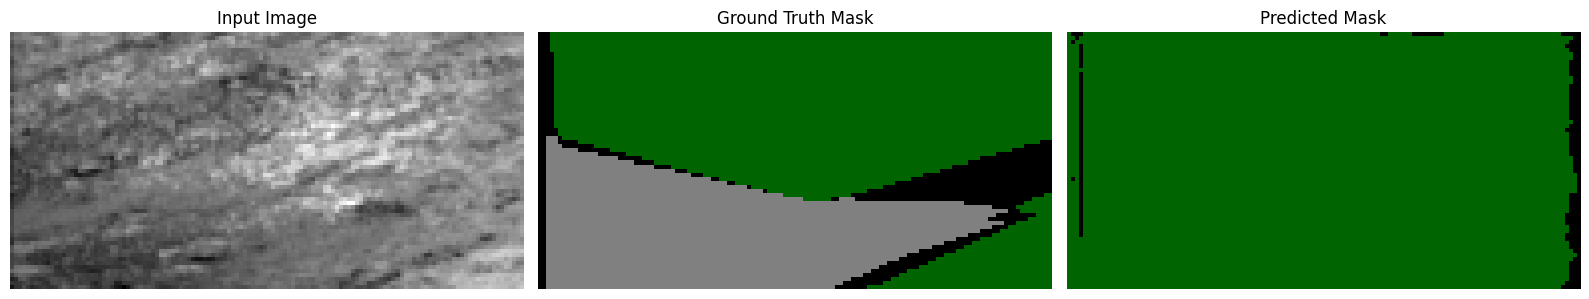

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.7932 - loss: 0.9720 - mean_iou: 0.5005 - val_accuracy: 0.7388 - val_loss: 1.1290 - val_mean_iou: 0.4222 - learning_rate: 1.0000e-05
Epoch 47/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.7917 - loss: 0.9718 - mean_iou: 0.5056 - val_accuracy: 0.7366 - val_loss: 1.1287 - val_mean_iou: 0.4173 - learning_rate: 1.0000e-05
Epoch 48/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - accuracy: 0.7950 - loss: 0.9661 - mean_iou: 0.5013 - val_accuracy: 0.7421 - val_loss: 1.1111 - val_mean_iou: 0.4253 - learning_rate: 1.0000e-05
Epoch 49/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 350ms/step - accuracy: 0.8013 - loss: 0.9515 - mean_iou: 0.5073 - val_accuracy: 0.7485 - val_loss: 1.0914 - val_mean_iou: 0.4307 - learning_rate: 1.0000e-05
Epoch 50/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.7925 - loss: 0.9674 - mean_iou: 0.5001 - val_accuracy: 0.7398 - val_loss: 1.1116 - val_mean_iou: 0.4208 - learning_rate: 1.0000e-05
Epoc

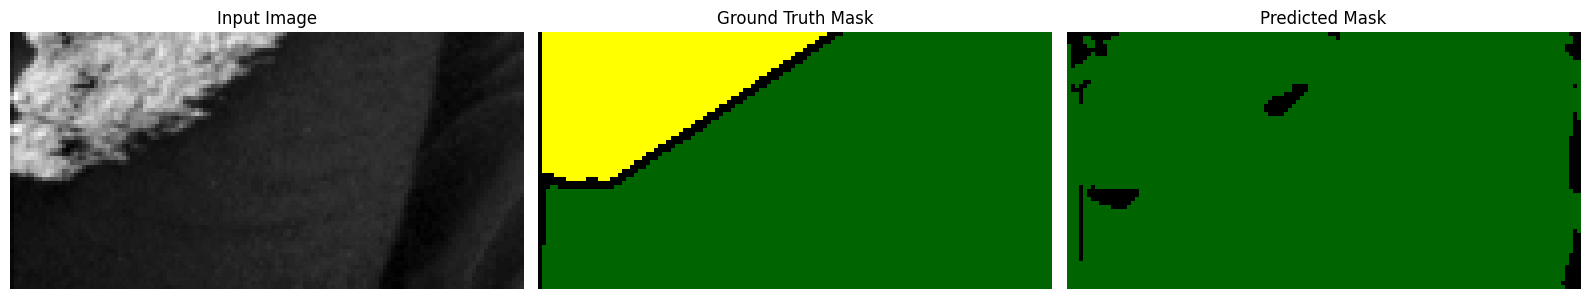

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 362ms/step - accuracy: 0.7992 - loss: 0.9493 - mean_iou: 0.5048 - val_accuracy: 0.7429 - val_loss: 1.0990 - val_mean_iou: 0.4248 - learning_rate: 1.0000e-05
Epoch 52/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.8040 - loss: 0.9413 - mean_iou: 0.5111 - val_accuracy: 0.7478 - val_loss: 1.0912 - val_mean_iou: 0.4314 - learning_rate: 1.0000e-05
Epoch 53/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.7980 - loss: 0.9539 - mean_iou: 0.5065 - val_accuracy: 0.7420 - val_loss: 1.0948 - val_mean_iou: 0.4246 - learning_rate: 1.0000e-05
Epoch 54/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 347ms/step - accuracy: 0.8019 - loss: 0.9409 - mean_iou: 0.5040 - val_accuracy: 0.7225 - val_loss: 1.1284 - val_mean_iou: 0.4011 - learning_rate: 1.0000e-05
Epoch 55/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.8078 - loss: 0.9306 - mean_iou: 0.5115 - val_accuracy: 0.7312 - val_loss: 1.1133 - val_mean_iou: 0.4127 - learning_rate: 1.0000e-05
Epoc

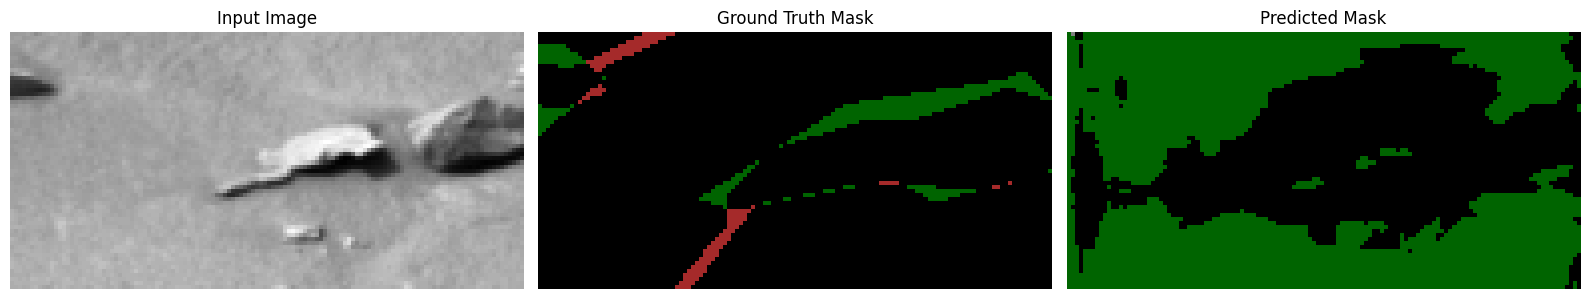

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.8081 - loss: 0.9269 - mean_iou: 0.5122 - val_accuracy: 0.7434 - val_loss: 1.0873 - val_mean_iou: 0.4269 - learning_rate: 1.0000e-06
Epoch 57/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.8129 - loss: 0.9145 - mean_iou: 0.5190 - val_accuracy: 0.7485 - val_loss: 1.0755 - val_mean_iou: 0.4334 - learning_rate: 1.0000e-06
Epoch 58/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.8087 - loss: 0.9202 - mean_iou: 0.5174 - val_accuracy: 0.7510 - val_loss: 1.0699 - val_mean_iou: 0.4364 - learning_rate: 1.0000e-06
Epoch 59/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - accuracy: 0.8128 - loss: 0.9180 - mean_iou: 0.5157 - val_accuracy: 0.7526 - val_loss: 1.0668 - val_mean_iou: 0.4384 - learning_rate: 1.0000e-06
Epoch 60/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8111 - loss: 0.9170 - mean_iou: 0.5154 - val_accuracy: 0.7601 - val_loss: 1.0535 - val_mean_iou: 0.4483 - learning_rate: 1.0000e-06
Epoc

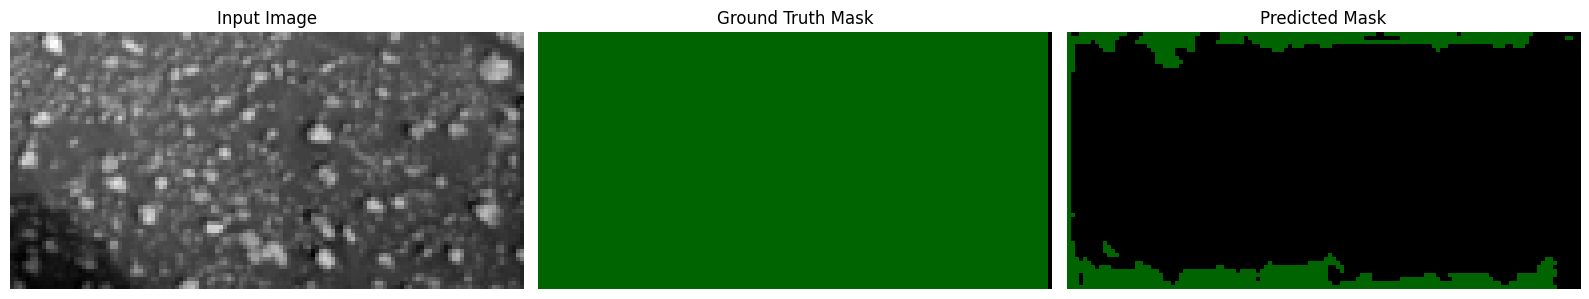

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 365ms/step - accuracy: 0.8059 - loss: 0.9282 - mean_iou: 0.5089 - val_accuracy: 0.7618 - val_loss: 1.0510 - val_mean_iou: 0.4506 - learning_rate: 1.0000e-06
Epoch 62/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.8123 - loss: 0.9184 - mean_iou: 0.5116 - val_accuracy: 0.7655 - val_loss: 1.0464 - val_mean_iou: 0.4561 - learning_rate: 1.0000e-06
Epoch 63/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.8089 - loss: 0.9254 - mean_iou: 0.5142 - val_accuracy: 0.7636 - val_loss: 1.0484 - val_mean_iou: 0.4536 - learning_rate: 1.0000e-06
Epoch 64/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.8129 - loss: 0.9121 - mean_iou: 0.5194 - val_accuracy: 0.7649 - val_loss: 1.0469 - val_mean_iou: 0.4555 - learning_rate: 1.0000e-06
Epoch 65/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.8118 - loss: 0.9161 - mean_iou: 0.5103 - val_accuracy: 0.7639 - val_loss: 1.0485 - val_mean_iou: 0.4541 - learning_rate: 1.0000e-06
Epoc

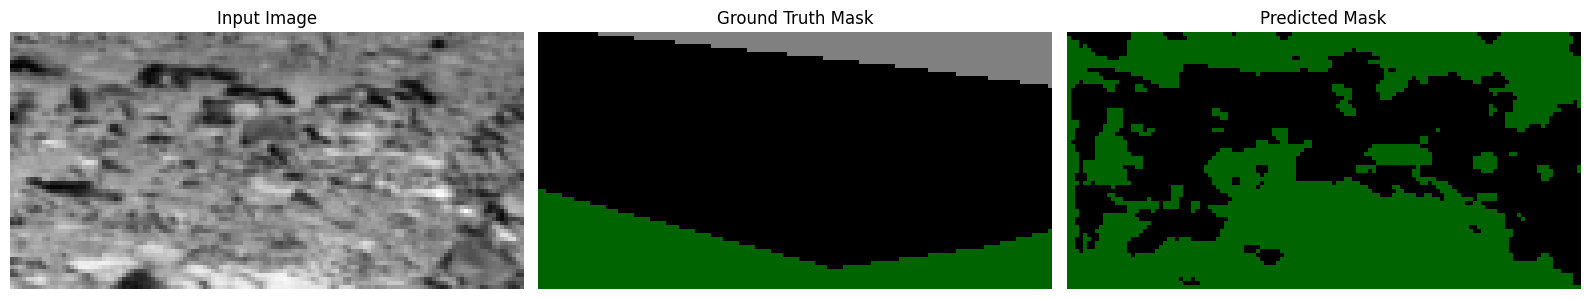

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.8079 - loss: 0.9206 - mean_iou: 0.5133 - val_accuracy: 0.7642 - val_loss: 1.0485 - val_mean_iou: 0.4546 - learning_rate: 1.0000e-06
Epoch 67/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.8076 - loss: 0.9261 - mean_iou: 0.5098 - val_accuracy: 0.7686 - val_loss: 1.0425 - val_mean_iou: 0.4620 - learning_rate: 1.0000e-06
Epoch 68/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.8161 - loss: 0.9085 - mean_iou: 0.5172 - val_accuracy: 0.7660 - val_loss: 1.0456 - val_mean_iou: 0.4578 - learning_rate: 1.0000e-06
Epoch 69/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.8137 - loss: 0.9139 - mean_iou: 0.5155 - val_accuracy: 0.7656 - val_loss: 1.0458 - val_mean_iou: 0.4572 - learning_rate: 1.0000e-06
Epoch 70/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.8164 - loss: 0.9068 - mean_iou: 0.5141 - val_accuracy: 0.7660 - val_loss: 1.0454 - val_mean_iou: 0.4582 - learning_rate: 1.0000e-06
Epoc

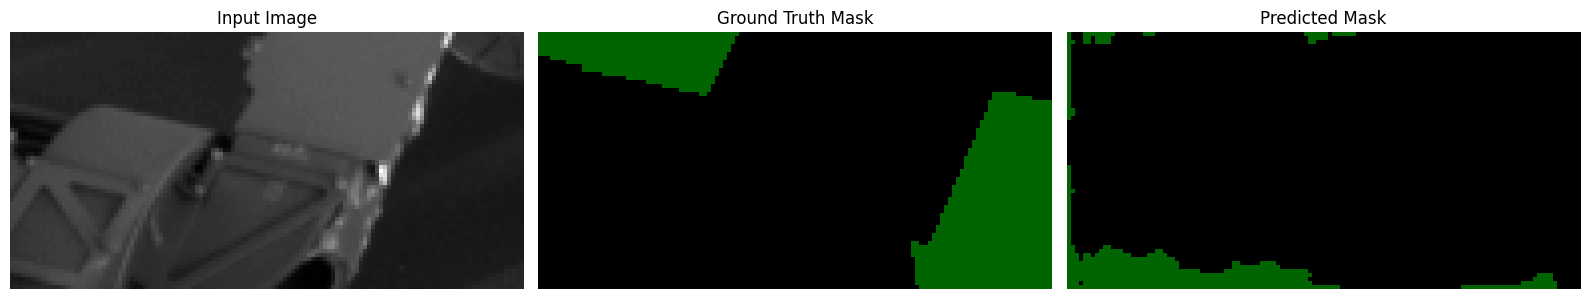

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.8087 - loss: 0.9206 - mean_iou: 0.5145 - val_accuracy: 0.7666 - val_loss: 1.0457 - val_mean_iou: 0.4596 - learning_rate: 1.0000e-06
Epoch 72/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.8152 - loss: 0.9097 - mean_iou: 0.5169 - val_accuracy: 0.7667 - val_loss: 1.0455 - val_mean_iou: 0.4594 - learning_rate: 1.0000e-06
Epoch 73/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 352ms/step - accuracy: 0.8151 - loss: 0.9066 - mean_iou: 0.5132 - val_accuracy: 0.7668 - val_loss: 1.0459 - val_mean_iou: 0.4601 - learning_rate: 1.0000e-06
Epoch 74/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.8160 - loss: 0.9058 - mean_iou: 0.5166 - val_accuracy: 0.7666 - val_loss: 1.0443 - val_mean_iou: 0.4598 - learning_rate: 1.0000e-06
Epoch 75/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.8141 - loss: 0.9069 - mean_iou: 0.5192 - val_accuracy: 0.7653 - val_loss: 1.0458 - val_mean_iou: 0.4581 - learning_rate: 1.0000e-06
Epoc

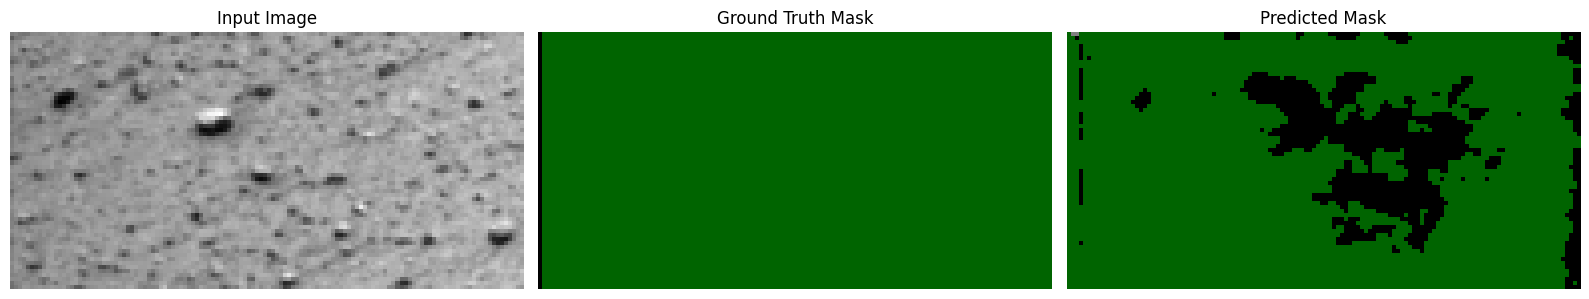

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.8120 - loss: 0.9125 - mean_iou: 0.5156 - val_accuracy: 0.7661 - val_loss: 1.0450 - val_mean_iou: 0.4594 - learning_rate: 1.0000e-06
Epoch 77/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.8146 - loss: 0.9063 - mean_iou: 0.5139 - val_accuracy: 0.7621 - val_loss: 1.0497 - val_mean_iou: 0.4532 - learning_rate: 1.0000e-06
Epoch 78/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.8195 - loss: 0.9026 - mean_iou: 0.5206 - val_accuracy: 0.7641 - val_loss: 1.0479 - val_mean_iou: 0.4562 - learning_rate: 1.0000e-07
Epoch 79/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - accuracy: 0.8150 - loss: 0.9067 - mean_iou: 0.5153 - val_accuracy: 0.7650 - val_loss: 1.0474 - val_mean_iou: 0.4579 - learning_rate: 1.0000e-07
Epoch 80/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.8140 - loss: 0.9055 - mean_iou: 0.5159 - val_accuracy: 0.7656 - val_loss: 1.0472 - val_mean_iou: 0.4589 - learning_rate: 1.0000e-07
Epoc

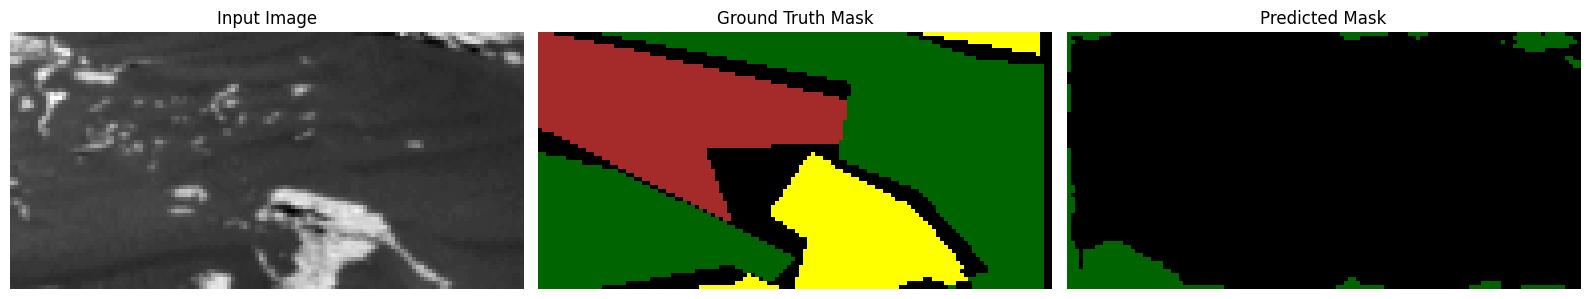

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 383ms/step - accuracy: 0.8198 - loss: 0.8928 - mean_iou: 0.5193 - val_accuracy: 0.7659 - val_loss: 1.0474 - val_mean_iou: 0.4592 - learning_rate: 1.0000e-07
Epoch 82/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 345ms/step - accuracy: 0.8126 - loss: 0.9108 - mean_iou: 0.5143 - val_accuracy: 0.7657 - val_loss: 1.0481 - val_mean_iou: 0.4589 - learning_rate: 1.0000e-07
Epoch 83/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - accuracy: 0.8142 - loss: 0.9072 - mean_iou: 0.5155 - val_accuracy: 0.7660 - val_loss: 1.0478 - val_mean_iou: 0.4595 - learning_rate: 1.0000e-07
Epoch 84/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.8193 - loss: 0.8953 - mean_iou: 0.5218 - val_accuracy: 0.7662 - val_loss: 1.0478 - val_mean_iou: 0.4599 - learning_rate: 1.0000e-07
Epoch 85/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.8164 - loss: 0.8972 - mean_iou: 0.5154 - val_accuracy: 0.7665 - val_loss: 1.0476 - val_mean_iou: 0.4605 - learning_rate: 1.0000e-07
Epoc

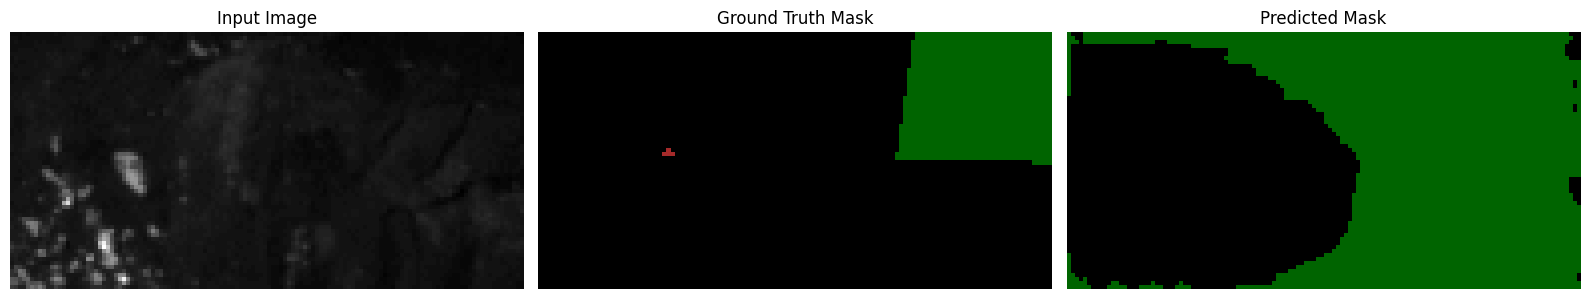

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.8146 - loss: 0.9030 - mean_iou: 0.5158 - val_accuracy: 0.7662 - val_loss: 1.0476 - val_mean_iou: 0.4600 - learning_rate: 1.0000e-07
Epoch 87/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.8145 - loss: 0.9057 - mean_iou: 0.5138 - val_accuracy: 0.7662 - val_loss: 1.0478 - val_mean_iou: 0.4600 - learning_rate: 1.0000e-07
Epoch 88/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.8185 - loss: 0.8972 - mean_iou: 0.5200 - val_accuracy: 0.7663 - val_loss: 1.0479 - val_mean_iou: 0.4603 - learning_rate: 1.0000e-08
Epoch 89/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.8161 - loss: 0.9019 - mean_iou: 0.5177 - val_accuracy: 0.7662 - val_loss: 1.0480 - val_mean_iou: 0.4602 - learning_rate: 1.0000e-08
Epoch 90/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.8162 - loss: 0.9021 - mean_iou: 0.5157 - val_accuracy: 0.7663 - val_loss: 1.0480 - val_mean_iou: 0.4602 - learning_rate: 1.0000e-08
Epoc

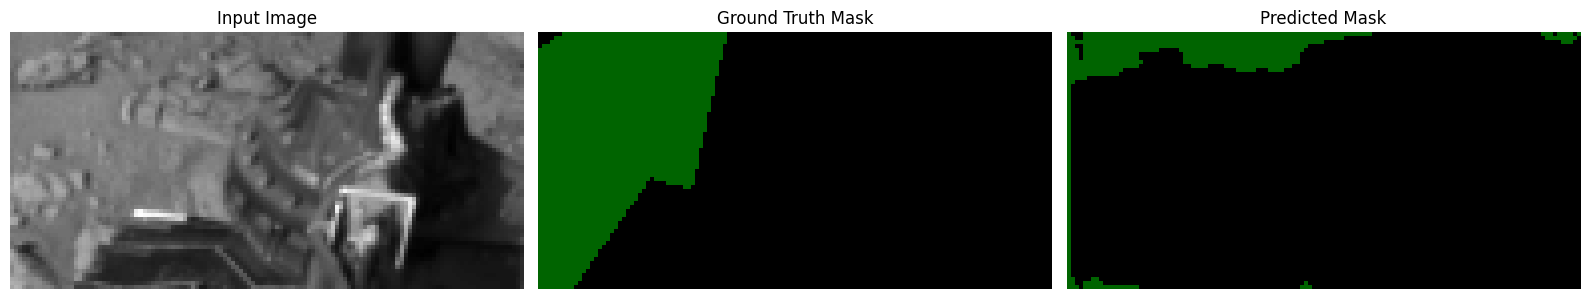

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.8160 - loss: 0.9036 - mean_iou: 0.5154 - val_accuracy: 0.7662 - val_loss: 1.0481 - val_mean_iou: 0.4602 - learning_rate: 1.0000e-08
Epoch 92/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.8119 - loss: 0.9153 - mean_iou: 0.5068 - val_accuracy: 0.7662 - val_loss: 1.0481 - val_mean_iou: 0.4602 - learning_rate: 1.0000e-08
Epoch 93/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.8109 - loss: 0.9139 - mean_iou: 0.5120 - val_accuracy: 0.7662 - val_loss: 1.0482 - val_mean_iou: 0.4602 - learning_rate: 1.0000e-08
Epoch 94/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.8163 - loss: 0.9045 - mean_iou: 0.5123 - val_accuracy: 0.7662 - val_loss: 1.0481 - val_mean_iou: 0.4602 - learning_rate: 1.0000e-08
Epoch 95/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.8149 - loss: 0.9043 - mean_iou: 0.5171 - val_accuracy: 0.7662 - val_loss: 1.0482 - val_mean_iou: 0.4602 - learning_rate: 1.0000e-08
Epoc

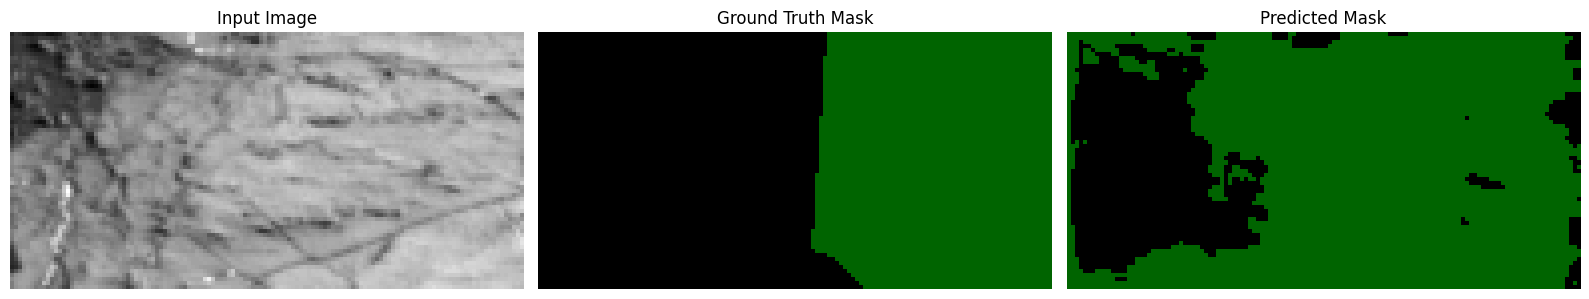

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step - accuracy: 0.8161 - loss: 0.9009 - mean_iou: 0.5168 - val_accuracy: 0.7662 - val_loss: 1.0482 - val_mean_iou: 0.4602 - learning_rate: 1.0000e-08
Epoch 97/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - accuracy: 0.8177 - loss: 0.8980 - mean_iou: 0.5226 - val_accuracy: 0.7662 - val_loss: 1.0481 - val_mean_iou: 0.4603 - learning_rate: 1.0000e-08
Final validation Mean Intersection Over Union: 46.2%


In [25]:
# Training del modello
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_plateau, viz_callback],
    verbose=1
).history


# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

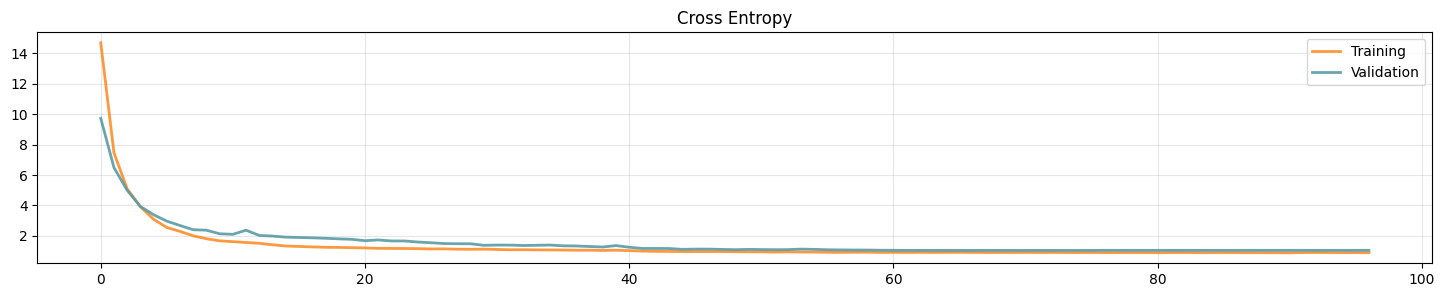

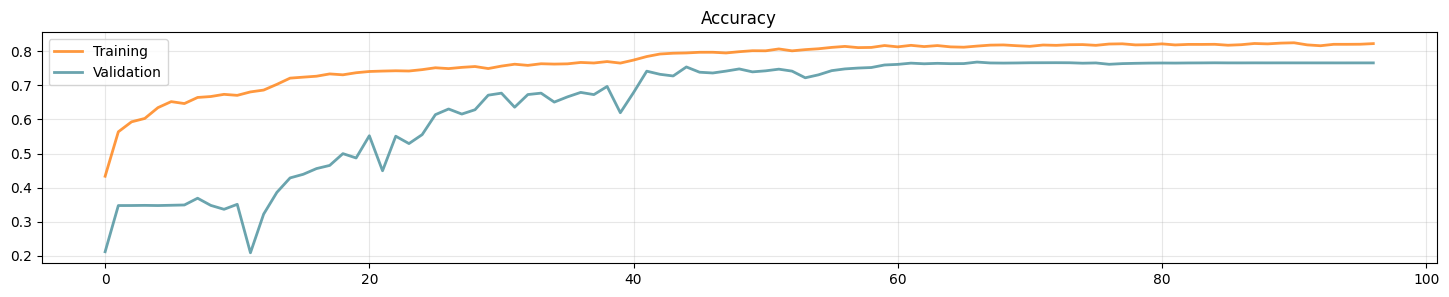

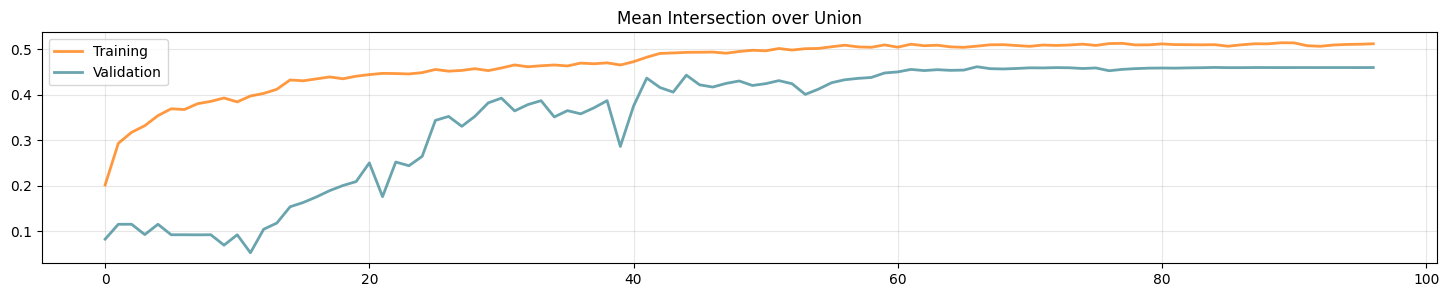

In [26]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Visualize prediction validation set

In [27]:
y_val_pred = model.predict(val_dataset)
y_val_pred = np.argmax(y_val_pred, axis=-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 391ms/step


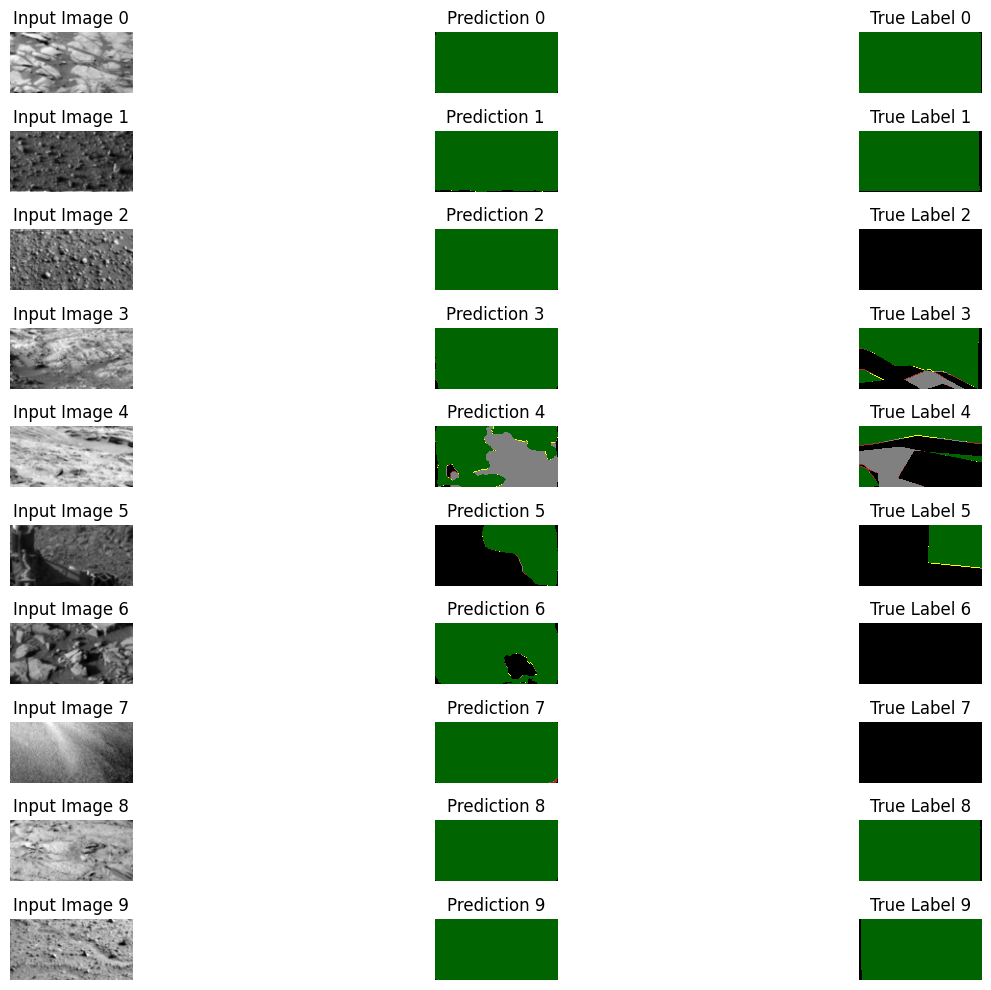

In [28]:
def display_images_with_predictions_and_true_labels(input_images, predictions, true_labels, start=0, end=5, figsize=(15, 10)):
    """
    Display input images, model predictions, and true labels for visual comparison.

    Parameters:
    - input_images: Array of input images (e.g., grayscale terrain images).
    - predictions: Array of predicted segmentation masks (output from the model).
    - true_labels: Array of ground truth segmentation masks.
    - start: Index to start the display from.
    - end: Index to stop the display at (inclusive).
    - figsize: Size of the figure for plotting.
    """

    # Set up the figure for displaying images
    fig, axes = plt.subplots(end - start, 3, figsize=figsize)

    for i in range(start, end):
        # Display the input image
        axes[i-start, 0].imshow(input_images[i, :, :, 0], cmap='gray')
        axes[i-start, 0].set_title(f'Input Image {i}')
        axes[i-start, 0].axis('off')

        # Display the predicted mask
        axes[i-start, 1].imshow(predictions[i, :, :], cmap=cmap)  # Use a color map for prediction
        axes[i-start, 1].set_title(f'Prediction {i}')
        axes[i-start, 1].axis('off')

        # Display the true mask
        axes[i-start, 2].imshow(true_labels[i, :, :], cmap=cmap)  # Use the same color map for ground truth
        axes[i-start, 2].set_title(f'True Label {i}')
        axes[i-start, 2].axis('off')

    plt.tight_layout()
    plt.show()

display_images_with_predictions_and_true_labels(val_img, y_val_pred, val_lbl, start=0, end=10)

In [29]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def compute_metrics(y_true, y_pred, num_classes=5):
    """
    Compute precision, recall, and accuracy for segmentation tasks.
    Parameters:
    - y_true: Ground truth labels (numpy array).
    - y_pred: Predicted labels (numpy array).
    - num_classes: Number of classes (including background).

    Returns:
    - precision: Per-class precision.
    - recall: Per-class recall.
    - accuracy: Overall accuracy.
    """
    # Flatten the arrays for metric calculation
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Precision and Recall for each class
    precision = precision_score(y_true_flat, y_pred_flat, average=None, labels=np.arange(num_classes))
    recall = recall_score(y_true_flat, y_pred_flat, average=None, labels=np.arange(num_classes))

    # Overall Accuracy
    accuracy = accuracy_score(y_true_flat, y_pred_flat)

    return precision, recall, accuracy

# Compute metrics
precision, recall, accuracy = compute_metrics(val_lbl, y_val_pred, num_classes=5)

# Print results
print(f"Precision (per class): {precision}")
print(f"Recall (per class): {recall}")
print(f"Overall Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision (per class): [0.65714561 0.80894493 0.7600777  0.81566503 0.        ]
Recall (per class): [0.56173007 0.90313293 0.73320528 0.83203494 0.        ]
Overall Accuracy: 0.768614382562999


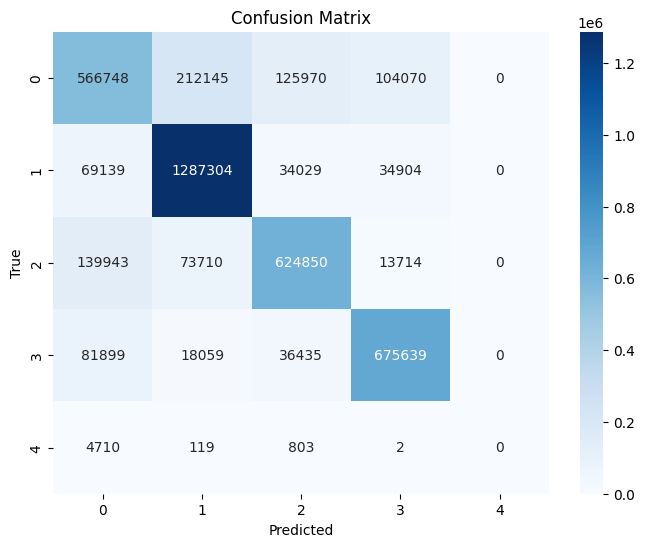

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, num_classes=num_classes):
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten(), labels=np.arange(num_classes))

    # Plot confusion matrix using Seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(val_lbl, y_val_pred)

**Osservazione:** dalla confusion matrix si rileva il fatto che la classe 4 non venga praticamente classificata. Inoltre abbiamo errori nella classificazione delle altre classi, in particolar modo la classe 0 e le altre classi vengono molto confuse. Miglioramento però rispetto alla singola U-net per la classificazione delle altre classi: per esempio la classe 0 vede 60.000 classificazioni corrette in più.

In [ ]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

In [ ]:
preds = model.predict(test_dataset)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

In [ ]:
# Visualize pred and image refere
display_images_with_masks(X_test, preds, start=5, end=10)

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)
print(f"Submission file saved to {submission_filename}")

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```